# Detecting Independence

In *Neural Conditional Probability for Uncertainty Quantification* (Kostic et al., 2024), the authors claim that the (deflated) conditional expectation operator can be used to detect the independence of two random variables X and Y by verifying whether it is zero. Here, we show this equivaliance in practice.

## Dataset

We consider the data model

$$Y = tX + (1-t)X',$$

where $X$ and $X'$ are independent standard Gaussians in $\mathbb{R}$, and $t \in [0,1]$ is an interpolating factor. This model allows us to explore both extreme cases ($t = 0$ for independence and $t = 1$ where $Y = X$) and the continuum in between, to assess the robustness of NCP in detecting independence.

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split


def make_dataset(n_samples: int = 200, t: float = 0.0):
    """Draw sample from data model Y = tX + (1-t)X_, where X and X_ are independent gaussians.

    If t = 0, then X and Y are independent. Otherwise, if t->1, X and Y become ever more dependent.

    Args:
        n_samples (int, optional): Number of samples. Defaults to 200.
        t (float, optional): Interpolation factor. Defaults to 0.0.
    """
    X = torch.normal(mean=0, std=1, size=(n_samples, 1))
    X_ = torch.normal(mean=0, std=1, size=(n_samples, 1))
    Y = t * X + (1 - t) * X_

    ds = TensorDataset(X, Y)

    # Split data into train and val sets
    train_ds, val_ds = random_split(ds, lengths=[0.85, 0.15])

    return train_ds, val_ds

## Learning the conditional expectation operator

Now, we go through the process of learning the conditional expectation operator $\mathbb{E}_{Y \mid X}: L^2_Y \mapsto L^2_X$

$$[\mathbb{E}_{Y \mid X}g](x) = \mathbb{E}[g(Y) \mid X = x],$$

where $g \in L^2_Y$. We begin by noting that, if $\{u_i\}_{i=1}^\infty$ and $\{v_j\}_{j=1}^\infty$ were orthonormal bases of $L^2_X$ and $L^2_Y$ [(Orthonormal basis wikipedia)](https://en.wikipedia.org/wiki/Orthonormal_basis), then we could see the conditional expectation operator as an (infinite) matrix $\mathbf{E}$, where

$$\mathbf{E}_{ij} = \langle u_i, \mathbb{E}_{Y \mid X}v_j \rangle_{L^2_X} = \mathbb{E}_X[u_i(X)[\mathbb{E}_{Y \mid X}v_j](X)] = \mathbb{E}_{XY}[u_i(X)v_j(Y)].$$

Hence, to learn the operator, we "only" need to learn the most important parts of $\mathbf{E}$. The standard way to deal with such problems is to restrict oneself to finite subspaces of $L^2_X$ and $L^2_Y$ and then learn the (finite) matrix there. This corresponds to finding orthonormal functions  $\{u_i\}_{i=1}^d$ and $\{v_j\}_{j=1}^d$ s.t.

$$\lVert \mathbb{E}_{Y \mid X} - \mathbb{E}_{Y \mid X}^d \rVert$$

is minimized, where $d \in \mathbb{N}$ is the dimension and $\mathbb{E}_{Y \mid X}^d$ is the truncated operator that acts on $span\{v_j\}_{j=1}^d$ and $span\{u_i\}_{i=1}^d$. The theoretical solution of this problem is given by the truncated (rank d) Singular Value Decomposition [(Low-rank matrix approximation wikipedia)](https://en.wikipedia.org/wiki/Low-rank_approximation), which also has the nice benefit of ordering the bases by their importance a la PCA, meaning that $u_1$ is more important than $u_2$, and so on and so forth.

## A representation learning problem

A key insight of Kostic et al. (2024) is that this problem corresponds to a representation learning problem, where the goal is to find latent variables $u,v \in \mathbb{R}^d$ that are

1. [(Whitened, wikipedia)](https://en.wikipedia.org/wiki/Whitening_transformation): $\mathbb{E}[u_i(X)u_j(X)] = \mathbb{E}[v_i(Y)v_j(Y)] = \delta_{ij}$; and
2. Minimize the contrastive loss

$$\frac{1}{N(N-1)}\sum_{i \neq j}\langle u_{i}, Sv_{j} \rangle^2 - \frac{2}{N}\sum_{i=1}\langle u_{i}, Sv_{i} \rangle,$$

where $S$ is the matrix of the conditional expectation operator on these subspaces/features, which can be learned end-to-end with backpropagation or estimated with running means.

## Representation learning in Torch

In [8]:
from torch.nn import Module
import torch
import math
from torch import Tensor


class _Matrix(Module):
    """Module representing the matrix form of the truncated conditional expectation operator."""

    def __init__(
        self,
        dim_u: int,
        dim_v: int,
    ) -> None:
        super().__init__()
        self.weights = torch.nn.Parameter(
            torch.normal(mean=0.0, std=2.0 / math.sqrt(dim_u * dim_v), size=(dim_u, dim_v))
        )

    def forward(self, v: Tensor) -> Tensor:
        """Forward pass of the truncated conditional expectation operator's matrix (v -> Sv)."""
        # TODO: Unify Pietro, Giacomo and Dani's ideas on how to normalize\symmetrize the operator.
        out = v @ self.weights.T
        return out


class NCP(Module):
    """Neural Conditional Probability in PyTorch.

    Args:
        embedding_x (Module): Neural embedding of x.
        embedding_dim_x (int): Latent dimension of x.
        embedding_y (Module): Neural embedding of y.
        embedding_dim_y (int): Latent dimension of y.
    """

    def __init__(
        self,
        embedding_x: Module,
        embedding_y: Module,
        embedding_dim_x: int,
        embedding_dim_y: int,
    ) -> None:
        super().__init__()
        self.U = embedding_x
        self.V = embedding_y

        self.dim_u = embedding_dim_x
        self.dim_v = embedding_dim_y

        self.S = _Matrix(self.dim_u, self.dim_v)

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        """Forward pass of NCP."""
        u = self.U(x)
        v = self.V(y)
        Sv = self.S(v)

        return u, Sv

## Training NCP

We now how to train the NCP module above with the contrastive loss from `linear_operator_learning.nn` with orthonormality regularization and standard deep learning techniques.

In [11]:
from torch.optim import Optimizer
from linear_operator_learning.nn import L2ContrastiveLoss
from linear_operator_learning.nn import functional as F


def train(
    ncp: NCP,
    train_dataloader: DataLoader,
    device: str,
    loss_fn: callable,
    gamma: float,
    optimizer: Optimizer,
) -> Tensor:
    """Training logic of NCP."""
    ncp.train()
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        u, Sv = ncp(x, y)
        _loss = loss_fn(u, Sv)

        # TODO: Implement orthonormality regularization
        reg = F.orthonormality_regularization(u, Sv)

        loss = _loss + gamma * reg

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [14]:
import torch
from linear_operator_learning.nn import MLP
from linear_operator_learning.nn.linalg import whitening

SEED = 1
REPEATS = 1
BATCH_SIZE = 256
N_SAMPLES = 5000
MLP_PARAMS = dict(
    output_shape=2,
    n_hidden=2,
    layer_size=32,
    activation=torch.nn.ELU,
    bias=False,
    iterative_whitening=False,
)
EPOCHS = 100
WHITENING_N_SAMPLES = 2000

torch.manual_seed(SEED)

# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

results = dict()
for t in torch.linspace(start=0, end=1, steps=11):
    for r in range(REPEATS):
        run_id = (round(t.item(), 2), r)
        print(f"run_id = {run_id}")

        # Load data_________________________________________________________________________________
        train_ds, val_ds = make_dataset(n_samples=N_SAMPLES, t=t.item())

        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
        val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

        # Build NCP_________________________________________________________________________________
        ncp = NCP(
            embedding_x=MLP(input_shape=1, **MLP_PARAMS),
            embedding_dim_x=MLP_PARAMS["output_shape"],
            embedding_y=MLP(input_shape=1, **MLP_PARAMS),
            embedding_dim_y=MLP_PARAMS["output_shape"],
        ).to(device)

        # Train NCP_________________________________________________________________________________
        loss_fn = L2ContrastiveLoss()
        optimizer = torch.optim.Adam(ncp.parameters(), lr=5e-4)

        for epoch in range(EPOCHS):
            train(ncp, train_dl, device, loss_fn, 1e-3, optimizer)

        # Extract norm______________________________________________________________________________
        x = torch.normal(mean=0, std=1, size=(WHITENING_N_SAMPLES, 1)).to(device)
        x_ = torch.normal(mean=0, std=1, size=(WHITENING_N_SAMPLES, 1)).to(device)
        y = t * x + (1 - t) * x_
        u, Sv = ncp(x, y)

        _, _, svals, _, _ = whitening(u, Sv)
        results[run_id] = svals.max().item()

Using cpu device
run_id = (0.0, 0)
run_id = (0.1, 0)
run_id = (0.2, 0)
run_id = (0.3, 0)
run_id = (0.4, 0)
run_id = (0.5, 0)
run_id = (0.6, 0)
run_id = (0.7, 0)
run_id = (0.8, 0)
run_id = (0.9, 0)
run_id = (1.0, 0)


## Plots

<Axes: xlabel='t', ylabel='norm'>

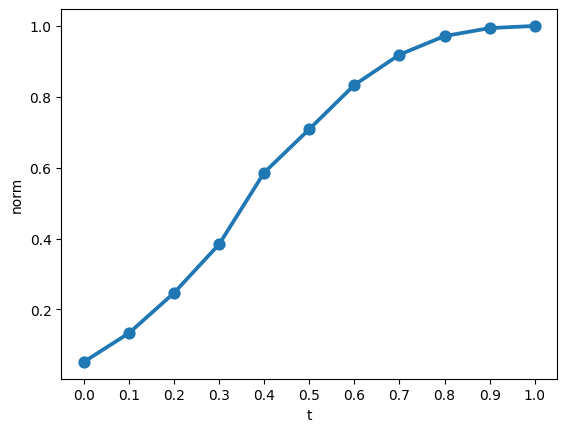

In [16]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame(
    data=[(t, r, norm) for ((t, r), norm) in results.items()],
    columns=["t", "r", "norm"],
)
sns.pointplot(results_df, x="t", y="norm")